# 프로젝트 개요

## 야간 이륜차 주행 사진으로 의미상 분할 작업을 수행하는 딥러닝 모델을 만듭니다.

[EN] To Develope a DL model of Semantic Segmentation with the Motorcycle Night Ride Dataset.

## 목표 제시

- 1차적으로 아래와 같은 작업이 잘 수행되는 것을 목표로 하고, 추가적으로 모델의 성능을 개선할 수 있는 방안을 시도합니다.

- 기본적인 접근 방법은 '케라스 창시자에게 배우는 딥러닝 2판'(길벗, 프랑수와 숄레 지음, 박해선 옮김)의 '이미지 분할 예제'(330쪽~338쪽)를 참고하였음을 밝힙니다.

# 계획

## 1. 이미지 전처리

- [ ]  데이터 다운로드
- [ ]  데이터 살펴보고 분석하기


## 2. 데이터 파이프라인 설계 및 구축

- [ ]  훈련, 검증, 테스트 셋으로 분할


## 3. 모델 구축 및 훈련

- [ ]  사전학습 모델사용은 불가
- [ ]  CV 층은 유넷(U-Net) 상속해서 사용
    - 추가로 다른 모델도 시도하면 추가점수
    
[ ]  컴파일 및 훈련 (콜백 유의!)
    - 콜백: 가장 성능좋은 모델, 텐서보드 로그 저장옵션
- [ ]  최초 훈련시 혼합정밀도 사용해서 성능 비교 후, 혼합정밀도 쪽에 큰 문제가 없으면 이후 모델 개선시 지속 사용 (556쪽)


## 4. 결과를 텐서보드로 시각화

책 267-269쪽


## 5. 하이퍼 파라미터 조정 등 다양한 개선기법 적용

- [ ]  손실점수 확인 및 개선방향 정의
    - [ ]  잔차 연결
    - [ ]  배치 정규화
- [ ]  중간 활성화 시각화? (시맨틱 분할에도 할게 있나?)
- [ ]  케라스 튜너 사용? (544쪽)
- [ ]  모델 앙상블(551쪽)
- [ ]  양자화(554쪽) - 훈련속도가 느릴 경우

## 1. 이미지 전처리

이미지가 들어있는 디렉토리에는 동일 장면에 대한 사진 원본, 시맨틱 세그먼트 마스크, 분할된 객체를 재현하여 합성한 저장 이미지 각 세 장씩이 존재합니다. 

In [1]:
!ls ./data/images

origin	saved  target


입력 이미지 크기 및 채널: (1080, 1920, 4)
입력 이미지 갯수: 200


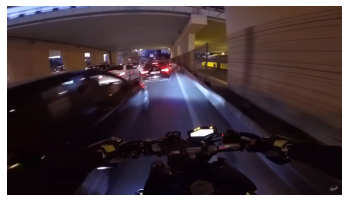

In [2]:
# 입력 이미지 확인하기
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img
input_img_dir = './data/images/origin/'
input_img_paths = sorted([os.path.join(input_img_dir, fname)
                         for fname in os.listdir(input_img_dir)
                         if fname.endswith('.png')])
plt.axis('off')
plt.imshow(load_img(input_img_paths[11]))
print(f'입력 이미지 크기 및 채널: {plt.imread(input_img_paths[11]).shape}')
print(f'입력 이미지 갯수: {len(input_img_paths)}')

이미지 크기 및 채널: (1080, 1920, 4)
입력 이미지 갯수: 200


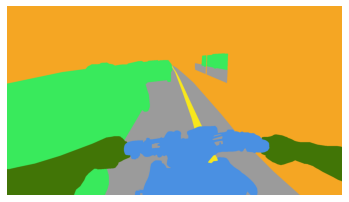

In [3]:
# 타겟 이미지 확인하기
target_dir = './data/images/target/'
target_paths = sorted([os.path.join(target_dir, fname)
                         for fname in os.listdir(target_dir)
                         if fname.endswith('.png')])

plt.axis('off')
plt.imshow(load_img(target_paths[11]))
print(f'이미지 크기 및 채널: {plt.imread(target_paths[11]).shape}')
print(f'입력 이미지 갯수: {len(target_paths)}')

경계가 없이, 객체를 6개로 구분한 것으로 보입니다. 데이터셋 설명에 따르면 안움직이는 것(Undrivable - 주황), 길(회색), 차선(노랑), 이륜차(파랑), 이륜차 운전자(진녹), 움직이는 것(Movable - 연녹)으로 나뉩니다.

In [4]:
# 라벨을 지정하기 위해 컬러값을 확인합니다.
import numpy as np
from PIL import Image

# 이미지 불러오기
img = Image.open(target_paths[11])

# 이미지를 NumPy 배열로 변환
img_array = np.array(img)

# 유니크한 컬러값 찾기
unique_colors = np.unique(img_array.reshape(-1, img_array.shape[2]), axis=0)

# 6개의 컬러값만 확인
if len(unique_colors) >= 6:
    print("Found colors:", unique_colors[:6])
else:
    print("Less than 6 unique colors found:", unique_colors)

Found colors: [[ 57 234  92 255]
 [ 65 117   6 255]
 [ 74 144 226 255]
 [155 155 155 255]
 [245 166  35 255]
 [248 231  28 255]]


In [5]:
import random
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import load_img

img_size = (216, 384)
num_imgs = len(input_img_paths)
colors = [
    [57, 234, 92],
    [65, 117, 6],
    [74, 144, 226],
    [155, 155, 155],
    [245, 166, 35],
    [248, 231, 28]]

random.Random(1103).shuffle(input_img_paths)
random.Random(1103).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path, colors): # 이미지 경로와 마스크 레이블 컬러를 타겟 데이터의 마지막 축 값으로 지정
    img = img_to_array(load_img(path, target_size=img_size))  # color_mode 제거
    
    labels = np.zeros(img.shape[:2], dtype="uint8")

    colors = colors

    for i, color in enumerate(colors):
        mask = np.all(img[:, :, :3] == np.array(color), axis=-1)
        labels[mask] = i
        
    return labels[..., np.newaxis]  # 마지막 축 추가

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i], colors)

num_val_samples = 40
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]


## 3. 모델 구축 및 훈련

### '케라스 창시자에게 배우는 딥러닝' 예제 모델(333쪽-334쪽)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=6)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 216, 384, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 216, 384, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 108, 192, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 108, 192, 64)      36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 54, 96, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 96, 128)       147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 27, 48, 256)       295168

In [7]:
# 모델 컴파일 및 훈련
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('1st_ConvNet_semantic_segment_keras',
    save_best_only=True)
]
tensorboard = keras.callbacks.TensorBoard(
    log_dir='/log',)

history_ex = model.fit(train_input_imgs, train_targets,
                   epochs=20,
                   callbacks=callbacks,
                   batch_size=40,
                   validation_data=(val_input_imgs, val_targets))

Epoch 1/20
4/4 [==============================] - 17s 864ms/step - loss: 2.2420 - val_loss: 1.7677
INFO:tensorflow:Assets written to: 1st_ConvNet_semantic_segment_keras/assets
Epoch 2/20
4/4 [==============================] - 3s 775ms/step - loss: 1.7662 - val_loss: 1.7484
INFO:tensorflow:Assets written to: 1st_ConvNet_semantic_segment_keras/assets
Epoch 3/20
4/4 [==============================] - 3s 774ms/step - loss: 1.9333 - val_loss: 1.7384
INFO:tensorflow:Assets written to: 1st_ConvNet_semantic_segment_keras/assets
Epoch 4/20
4/4 [==============================] - 3s 775ms/step - loss: 1.7082 - val_loss: 2.0680
Epoch 5/20
4/4 [==============================] - 3s 776ms/step - loss: 1.8545 - val_loss: 1.6983
INFO:tensorflow:Assets written to: 1st_ConvNet_semantic_segment_keras/assets
Epoch 6/20
4/4 [==============================] - 3s 777ms/step - loss: 1.6492 - val_loss: 1.5084
INFO:tensorflow:Assets written to: 1st_ConvNet_semantic_segment_keras/assets
Epoch 7/20
4/4 [==========

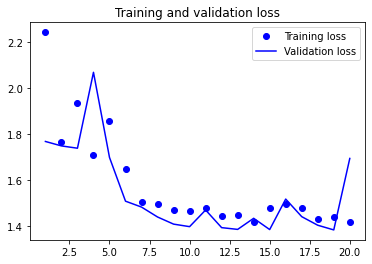

In [8]:
epochs = range(1, len(history_ex.history["loss"]) + 1)
loss = history_ex.history["loss"]
val_loss = history_ex.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

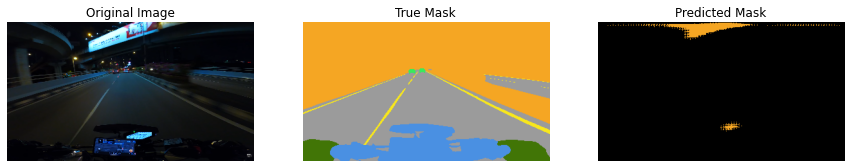

In [9]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("1st_ConvNet_semantic_segment_keras")

# 원본 이미지, 정답 마스크, 예측 마스크 출력
def mask_to_colored_mask(mask, colors):
    # 원-핫 인코딩된 마스크인지, 클래스 인덱스 마스크인지 확인
    if mask.shape[-1] == len(colors):
        mask_colored = np.zeros((*mask.shape[:-1], 3))
        for i, color in enumerate(colors):
            mask_colored[mask[..., i] > 0.5] = color
    else:  # 클래스 인덱스 마스크의 경우
        mask_colored = np.take(colors, mask[..., 0].astype(int), axis=0)
        
    return mask_colored.astype(np.uint8)

i = 5
test_image = val_input_imgs[i]
true_mask = val_targets[i]

predicted_mask = model.predict(np.expand_dims(test_image, 0))[0]
colored_predicted_mask = mask_to_colored_mask(predicted_mask, colors)
colored_true_mask = mask_to_colored_mask(true_mask, colors)

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

axarr[0].axis("off")
axarr[0].imshow(array_to_img(test_image))
axarr[0].set_title('Original Image')

axarr[1].axis("off")
axarr[1].imshow(colored_true_mask)
axarr[1].set_title('True Mask')

axarr[2].axis("off")
axarr[2].imshow(colored_predicted_mask)
axarr[2].set_title('Predicted Mask')

plt.show()


예측 결과를 보면, 대부분의 픽셀이 값을 결정하지 못한채로 시커멓게 비어있는 것을 확인할 수 있습니다. 즉, 모델의 성능이 그리 좋지가 않군요. 훈련 데이터로 사용하는 사진 숫자가 적은 것이 문제일 수도 있고, 모델의 설계 문제일 수도 있습니다.

이어서 순서대로 U-Net 구조와 데이터 증강을 적용해서 좀 더 개선된 성능을 나타내는지 시도해보겠습니다.

### U-Net 모델(333쪽-334쪽)

In [16]:
import tensorflow as tf
from tensorflow.keras import layers

def get_model_UNet(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))
    
    # Contracting path
    x = layers.Conv2D(64, 3, padding='same', activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(128, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(256, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(512, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(1024, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding='same', activation="relu")(x)
    x = layers.Conv2D(512, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(512, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', activation="relu")(x)
    x = layers.Conv2D(256, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', activation="relu")(x)
    x = layers.Conv2D(128, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', activation="relu")(x)
    x = layers.Conv2D(64, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, padding='same', activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

model_UNet = get_model_UNet(img_size=img_size, num_classes=6)
model_UNet.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 216, 384, 3)]     0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 216, 384, 64)      1792      
_________________________________________________________________
batch_normalization_34 (Batc (None, 216, 384, 64)      256       
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 216, 384, 64)      36928     
_________________________________________________________________
batch_normalization_35 (Batc (None, 216, 384, 64)      256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 108, 192, 64)      0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 108, 192, 128)     7385

In [17]:
# 모델 컴파일 및 훈련
model_UNet.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('2nd_UNet_semantic_segment_keras',
    save_best_only=True)
]
tensorboard = keras.callbacks.TensorBoard(
    log_dir='/log',)

history_UNet = model_UNet.fit(train_input_imgs, train_targets,
                   epochs=20,
                   callbacks=callbacks,
                   batch_size=30,
                   validation_data=(val_input_imgs, val_targets))

Epoch 1/20


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [2396160,6] and labels shape [2488320]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at tmp/ipykernel_47/2723927355.py:10) ]] [Op:__inference_train_function_74211]

Function call stack:
train_function


In [ ]:
epochs = range(1, len(history_UNet.history["loss"]) + 1)
loss = history_UNet.history["loss"]
val_loss = history_UNet.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

첫 에포크의 훈련로스가 너무 커서 제대로 읽을 수가 없으므로, 첫 에포크를 제외한 나머지를 기존의 예제 성능과 비교하는 형태로 그래프를 다시 그려보겠습니다.

In [ ]:
epochs = range(2, len(history_UNet.history["loss"]) + 1)

# history_UNet의 값
loss_UNet = history_UNet.history["loss"][1:]
val_loss_UNet = history_UNet.history["val_loss"][1:]

# history_ex의 값
loss_ex = history_ex.history["loss"][1:]
val_loss_ex = history_ex.history["val_loss"][1:]

plt.figure()

# history_UNet의 그래프
plt.plot(epochs, loss_UNet, "bo", label="Training loss (UNet)")
plt.plot(epochs, val_loss_UNet, "b", label="Validation loss (UNet)")

# history_ex의 그래프
plt.plot(epochs, loss_ex, "ro", label="Training loss (Ex)")
plt.plot(epochs, val_loss_ex, "r", label="Validation loss (Ex)")

plt.title("Training and validation loss comparison")
plt.legend()


In [ ]:
model = keras.models.load_model("2nd_UNet_semantic_segment_keras")

i = 5
test_image = val_input_imgs[i]
true_mask = val_targets[i]

predicted_mask = model.predict(np.expand_dims(test_image, 0))[0]
colored_predicted_mask = mask_to_colored_mask(predicted_mask, colors)
colored_true_mask = mask_to_colored_mask(true_mask, colors)

fig, axarr = plt.subplots(1, 3, figsize=(15, 5))

axarr[0].axis("off")
axarr[0].imshow(array_to_img(test_image))
axarr[0].set_title('Original Image')

axarr[1].axis("off")
axarr[1].imshow(colored_true_mask)
axarr[1].set_title('True Mask')

axarr[2].axis("off")
axarr[2].imshow(colored_predicted_mask)
axarr[2].set_title('Predicted Mask')

plt.tight_layout()
plt.show()


성능 그래프와 예측 마스크 결과를 보면 U-Net이 다소 나아보이는 듯하지만 여전히 만족스러운 결과는 아닙니다. 이미지 증강을 통해서 개선해보겠습니다.

### 이미지 증강

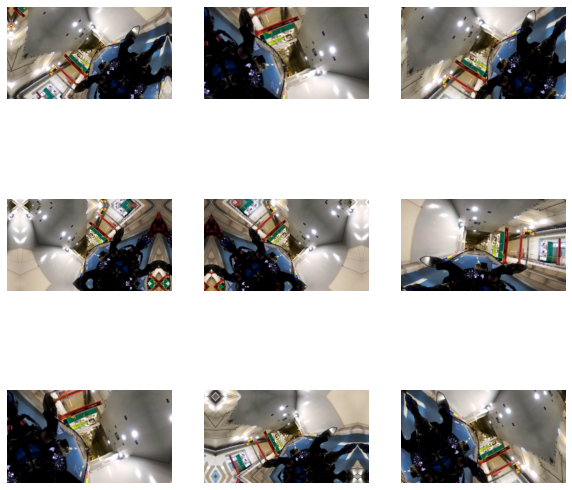

In [13]:
from tensorflow.keras import Sequential
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.3),
])

# 이미지 배열을 tf.data.Dataset으로 변환
dataset = tf.data.Dataset.from_tensor_slices(input_imgs).batch(32)

# 데이터 증강을 적용하고 결과를 출력
plt.figure(figsize=(10, 10))
for images in dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
# 이미지 증강 레이어 추가한 모델 작성
def get_model_UNet_img_augmented(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))
    
    # Apply data augmentation to the inputs
    x = data_augmentation(inputs)
    
    # Contracting path
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(num_classes, 6, activation="softmax", padding="same")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

model_UNet_img_augmented = get_model_UNet_img_augmented(img_size=img_size, num_classes=6)
model_UNet_img_augmented.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 216, 384, 3)]     0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 216, 384, 64)      1792      
_________________________________________________________________
batch_normalization_17 (Batc (None, 216, 384, 64)      256       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 216, 384, 64)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 216, 384, 64)      36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 216, 384, 64)      256       
_________________________________________________________________
re_lu_18 (ReLU)              (None, 216, 384, 64)      0   

In [15]:
# 모델 컴파일 및 훈련
model_UNet_img_augmented.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
callbacks = [
    keras.callbacks.ModelCheckpoint('3rd_UNet_semantic_segment_img_augmented_keras',
    save_best_only=True)
]
tensorboard = keras.callbacks.TensorBoard(
    log_dir='/log',)

history_UNet_img_augmented = model_UNet_img_augmented.fit(train_input_imgs, train_targets,
                   epochs=20,
                   callbacks=callbacks,
                   batch_size=30,
                   validation_data=(val_input_imgs, val_targets))

Epoch 1/20


InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [2396160,6] and labels shape [2488320]
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at tmp/ipykernel_47/1495847343.py:10) ]] [Op:__inference_train_function_68618]

Function call stack:
train_function


In [ ]:
epochs = range(2, len(history_UNet.history["loss"]) + 1)

# history_UNet의 값
loss_UNet = history_UNet.history["loss"][1:]
val_loss_UNet = history_UNet.history["val_loss"][1:]

# history_UNet_img_augmented의 값
loss_img_augmented = history_UNet_img_augmented.history["loss"][1:]
val_loss_img_augmented = history_UNet_img_augmented.history["val_loss"][1:]

plt.figure()

# history_UNet의 그래프
plt.plot(epochs, loss_UNet, "bo", label="Training loss (UNet)")
plt.plot(epochs, val_loss_UNet, "b", label="Validation loss (UNet)")

# history_UNet_img_augmented의 그래프
plt.plot(epochs, loss_img_augmented, "ro", label="Training loss (W/ Augmented Images)")
plt.plot(epochs, val_loss_img_augmented, "r", label="Validation loss (W/ Augmented Images)")

plt.title("Training and validation loss comparison")
plt.legend()


In [ ]:
# Load models
model_wo_augmentation = keras.models.load_model("2nd_UNet_semantic_segment_keras")
model_with_augmentation = keras.models.load_model("3rd_UNet_semantic_segment_img_augmented_keras")

# Choose the index for the image to visualize
i = 5

test_image = val_input_imgs[i]
true_mask = val_targets[i]

# Predict masks without and with augmentation
predicted_mask_wo_aug = model_wo_augmentation.predict(np.expand_dims(test_image, 0))[0]
predicted_mask_with_aug = model_with_augmentation.predict(np.expand_dims(test_image, 0))[0]

# Convert the masks to colored masks
colored_predicted_mask_wo_aug = mask_to_colored_mask(predicted_mask_wo_aug, colors)
colored_predicted_mask_with_aug = mask_to_colored_mask(predicted_mask_with_aug, colors)
colored_true_mask = mask_to_colored_mask(true_mask, colors)

# Plot
fig, axarr = plt.subplots(1, 4, figsize=(20, 5))

axarr[0].axis("off")
axarr[0].imshow(array_to_img(test_image))
axarr[0].set_title('Original Image')

axarr[1].axis("off")
axarr[1].imshow(colored_true_mask)
axarr[1].set_title('True Mask')

axarr[2].axis("off")
axarr[2].imshow(colored_predicted_mask_wo_aug)
axarr[2].set_title('Predicted Mask WO/Augmented Images')

axarr[3].axis("off")
axarr[3].imshow(colored_predicted_mask_with_aug)
axarr[3].set_title('Predicted Mask W/Augmented Images')

plt.tight_layout()
plt.show()


그래프 상의 최대 검증 로스에서도, 마스크 결과에서도 증강된 이미지가 더 좋은 효과를 나타내는 것을 확인할 수 있습니다.

## 마지막 개선 모델

In [ ]:
data_augmentation_2nd = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),   # 수평 및 수직으로 뒤집기
    layers.RandomRotation(0.1),  # 회전 범위를 0.2에서 0.1로 조정하여 더 적은 회전을 적용
    layers.RandomZoom(0.2, 0.2), # 줌 범위를 0.3에서 0.2로 조정
    layers.RandomContrast(0.2),  # 대비를 무작위로 조정
])

In [ ]:
# 두 번째 이미지 증강 레이어 추가한 모델 작성
def get_model_UNet_2nd_augmented(img_size, num_classes):
    inputs = tf.keras.Input(shape=img_size + (3,))
    
    # Apply data augmentation to the inputs
    x = data_augmentation_2nd(inputs)
    
    # Contracting path
    x = layers.Conv2D(64, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    
    x = layers.Conv2D(1024, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(512, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(512, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    outputs = layers.Conv2D(num_classes, 6, activation="softmax", padding="same")(x)
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

model_UNet_img_augmented_2nd = get_model_UNet_2nd_augmented(img_size=img_size, num_classes=6)
model_UNet_img_augmented_2nd.summary()

In [ ]:
# 학습률 스케줄러 추가
def lr_schedule(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    else:
        return 0.0001

    
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)

# 훈련 시 콜백에 학습률 스케줄러 추가
callbacks = [
    keras.callbacks.ModelCheckpoint('final_UNet_semantic_segment_keras',
    save_best_only=True)
]
callbacks.append(lr_scheduler)

history_UNet_img_augmented_2nd = model_UNet_img_augmented_2nd.fit(train_input_imgs, train_targets,
                   epochs=30,
                   callbacks=callbacks,
                   batch_size=30,
                   validation_data=(val_input_imgs, val_targets))

In [ ]:
epochs = range(2, len(history_UNet.history["loss"]) + 1)

# history_UNet의 값
loss_img_augmented_2ndt = history_UNet_img_augmented_2nd.history["loss"][1:]
val_loss_img_augmented_2nd = history_UNet_img_augmented_2nd.history["val_loss"][1:]

# history_UNet_img_augmented의 값
loss_img_augmented = history_UNet_img_augmented.history["loss"][1:]
val_loss_img_augmented = history_UNet_img_augmented.history["val_loss"][1:]

plt.figure()

# history_UNet의 그래프
plt.plot(epochs, loss_2nd_augmented, "bo", label="Training loss (UNet)")
plt.plot(epochs, val_loss_2nd_augmented, "b", label="Validation loss (UNet)")

# history_UNet_img_augmented의 그래프
plt.plot(epochs, loss_img_augmented, "ro", label="Training loss (W/ Augmented Images)")
plt.plot(epochs, val_loss_img_augmented, "r", label="Validation loss (W/ Augmented Images)")

plt.title("Training and validation loss comparison")
plt.legend()


In [ ]:
# Load models
model_wo_augmentation = keras.models.load_model("2nd_UNet_semantic_segment_keras")
model_with_augmentation = keras.models.load_model("3rd_UNet_semantic_segment_img_augmented_keras")

# Choose the index for the image to visualize
i = 5

test_image = val_input_imgs[i]
true_mask = val_targets[i]

# Predict masks without and with augmentation
predicted_mask_wo_aug = model_wo_augmentation.predict(np.expand_dims(test_image, 0))[0]
predicted_mask_with_aug = model_with_augmentation.predict(np.expand_dims(test_image, 0))[0]

# Convert the masks to colored masks
colored_predicted_mask_wo_aug = mask_to_colored_mask(predicted_mask_wo_aug, colors)
colored_predicted_mask_with_aug = mask_to_colored_mask(predicted_mask_with_aug, colors)
colored_true_mask = mask_to_colored_mask(true_mask, colors)

# Plot
fig, axarr = plt.subplots(1, 4, figsize=(20, 5))

axarr[0].axis("off")
axarr[0].imshow(array_to_img(test_image))
axarr[0].set_title('Original Image')

axarr[1].axis("off")
axarr[1].imshow(colored_true_mask)
axarr[1].set_title('True Mask')

axarr[2].axis("off")
axarr[2].imshow(colored_predicted_mask_wo_aug)
axarr[2].set_title('Predicted Mask WO/Augmented Images')

axarr[3].axis("off")
axarr[3].imshow(colored_predicted_mask_with_aug)
axarr[3].set_title('Predicted Mask W/Augmented Images')

plt.tight_layout()
plt.show()
